# Lab 5 Wide and Deep NN

Nicholas Larsen
Steven Larsen

# Loading in the Data
In this example, we are going to use crossed columns and embedding columns inside of a tensorflow object created with keras.

However, we will start the process by loading up a dataset with a mix of categorical data and numeric data. This dataset is quite old and has been used many times in machine learning examples: the census data from 1990's. We will use it to predict if a person will earn over or under 50k per year.

- https://archive.ics.uci.edu/ml/datasets/Census-Income+(KDD)
- This data goes by various name, including the "Adult" dataset and 1996 census data

In [1]:
import pandas as pd
import tensorflow as tf
import pandas as pd
from copy import deepcopy
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import concatenate
import tensorflow as tf
from sklearn import metrics as mt
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dense, Activation, Input
from tensorflow.keras.layers import Embedding, Flatten, Concatenate
from tensorflow.keras.models import Model
from sklearn import metrics as mt
from tensorflow import keras
import missingno as mn
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, ShuffleSplit
from tensorflow.keras.utils import plot_model
df_orig = pd.read_csv('..\insurance.csv')
X_cols = ['Gender', 'Age', 'Driving_License', 'Region_Code', 'Previously_Insured', 'Vehicle_Age',
         'Vehicle_Damage', 'Annual_Premium', 'Policy_Sales_Channel', 'Vintage']
Y_col = 'Response'
df_orig_X = df_orig[X_cols]
df_orig_y = df_orig[Y_col]

# Split into Train and Test

Since the dataset is so large, we can break off 20% that we will never use during training. Once a model is developed, to verify its performance we will perform Stratified 10 Fold on the 80%, to get the variance of how it will perform. Then we will train it on the entire 80% with the parameters chosen, and test on the leftover 20% that the model has never seen for a final perfomance.

In [2]:
X_train_orig_df, X_test_orig_df, y_train_orig_df, y_test_orig_df =\
    train_test_split(df_orig_X, df_orig_y, test_size=0.2, stratify=df_orig_y)

In [3]:
df_train = deepcopy(X_train_orig_df)
df_train['Repsone'] = deepcopy(y_train_orig_df)
df_test = deepcopy(X_test_orig_df)
df_test['Repsone'] = deepcopy(y_test_orig_df)

# Prepare Class Varibles

<AxesSubplot:>

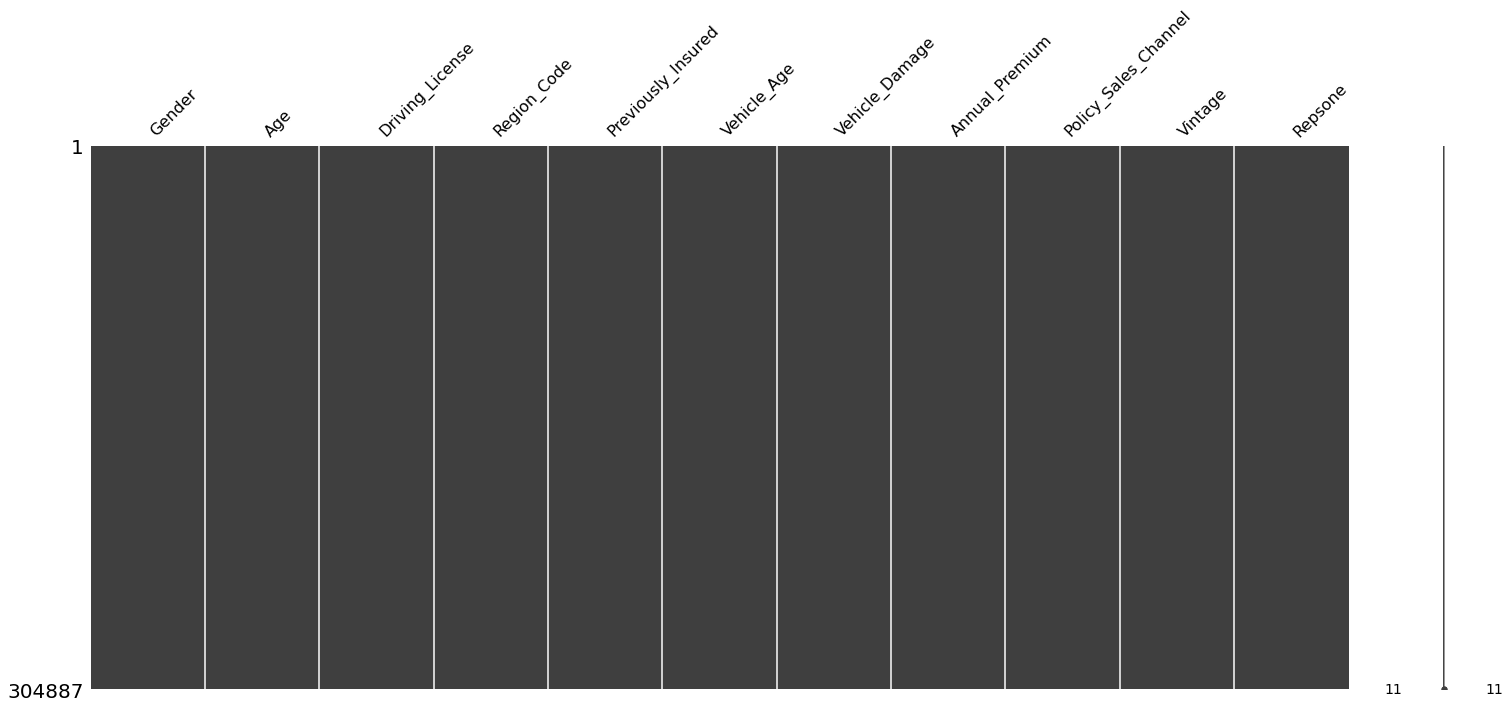

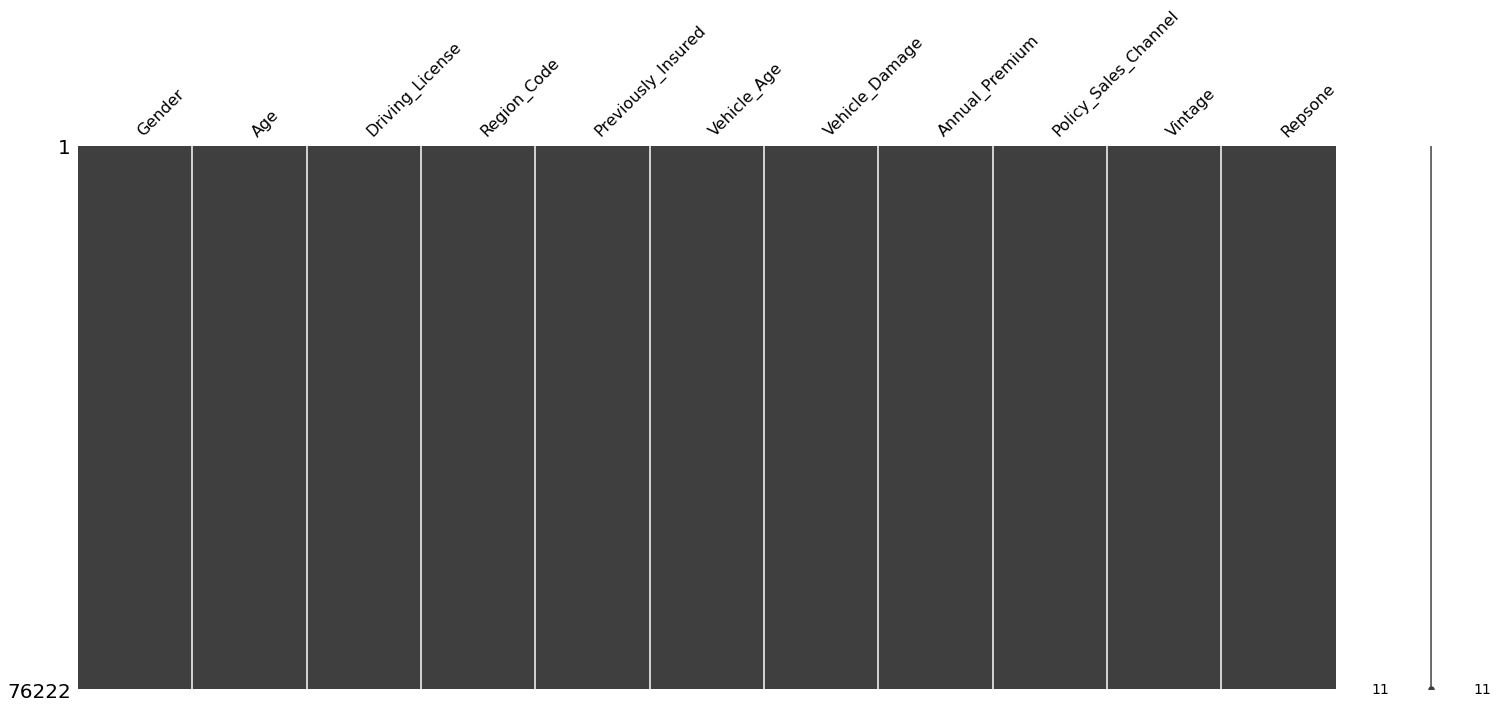

In [4]:
mn.matrix(df_train)
mn.matrix(df_test)

In [5]:
import numpy as np

# let's just get rid of rows with any missing data
# and then reset the indices of the dataframe so it corresponds to row number
df_train.dropna(inplace=True)
df_train.reset_index()

df_test.dropna(inplace=True)
df_test.reset_index()

df_test.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Repsone
168423,Female,74,1,28.0,1,1-2 Year,No,40998.0,26.0,73,0
125262,Male,52,1,28.0,0,1-2 Year,Yes,48091.0,26.0,257,1
366645,Male,39,1,28.0,0,1-2 Year,Yes,29535.0,37.0,115,0
110572,Female,55,1,28.0,0,1-2 Year,Yes,50877.0,26.0,69,0
366722,Male,52,1,46.0,0,1-2 Year,Yes,29877.0,26.0,73,0


The data is organized as follows: 

|Variable | description|
|----|--------|
|Gender: | Categorical|
|Age: | Continuous |
|Driving_License | 1 if they have a DL, 0 if not |
| Region_Code | Categorical |
| Previously_Insured | Boolean 1 yes, 0 no |
|Vehicle_Age | Treated as Categorical <1, 1-2, >2|
|Vehicle_Damage | Yes or No |
|Annual_Premium | Continuous |
|Policy_Sales_Channel | Categorical |
| Vintage | Legnth of time they were associated with the company |
|**Responce (target):**|1 if they took a policy, 0 if not| 

Our goal is to acheive a reacall score on the Response(target) of 90% for the positive cases. This will ensure that the model does not look over customers that are likely to enroll in a policy

Remove Policy channels that have less than 2 samples

In [6]:
drops = []

for channel in df_test['Policy_Sales_Channel'].unique():
    if channel not in df_train['Policy_Sales_Channel'].unique():
        drops.append(channel)
drops

for drop in drops:
    print(f"Dropping {len(df_test[df_test.Policy_Sales_Channel == drop])} samples from test with {drop} Channel")
    df_test = df_test[df_test.Policy_Sales_Channel != drop]
df_test

Dropping 1 samples from test with 41.0 Channel
Dropping 1 samples from test with 43.0 Channel
Dropping 2 samples from test with 74.0 Channel


,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Repsone
168423,Female,74,1,28.0,1,1-2 Year,No,40998.0,26.0,73,0
125262,Male,52,1,28.0,0,1-2 Year,Yes,48091.0,26.0,257,1
366645,Male,39,1,28.0,0,1-2 Year,Yes,29535.0,37.0,115,0
110572,Female,55,1,28.0,0,1-2 Year,Yes,50877.0,26.0,69,0
366722,Male,52,1,46.0,0,1-2 Year,Yes,29877.0,26.0,73,0
...,...,...,...,...,...,...,...,...,...,...,...
110170,Female,21,1,12.0,1,< 1 Year,No,33672.0,152.0,109,0
74777,Male,63,1,48.0,0,> 2 Years,Yes,2630.0,15.0,110,1
112805,Female,41,1,28.0,0,1-2 Year,Yes,50779.0,122.0,73,0
70413,Male,40,1,8.0,0,1-2 Year,Yes,27256.0,160.0,63,0


# Groups of Variables

'Gender','Policy_Sales_Channel'

'Vehicle_Age','Vehicle_Damage','Previously_Insured'

'Region_Code','Gender',

                

#### Making Crossed Columns
For this example, we are going to make embeddings for crossed columns. We will perform this step using `sklearn` 

Let's start simple with 
- branches of crossed categorical features as input 
- one branch for each crossed column

In [7]:
# define objects that can encode each variable as integer    
encoders = dict() 
categorical_headers = ['Gender','Region_Code','Previously_Insured',
                       'Vehicle_Age','Vehicle_Damage','Policy_Sales_Channel']

# train all encoders (special case the target 'income')
for col in categorical_headers:
    df_train[col] = df_train[col]
    df_test[col] = df_test[col]
    
    # integer encoded variables
    encoders[col] = LabelEncoder() # save the encoder
    df_train[col+'_int'] = encoders[col].fit_transform(df_train[col])
    df_test[col+'_int'] = encoders[col].transform(df_test[col])

# scale the numeric, continuous variables
numeric_headers = ["Age", "Annual_Premium", "Vintage"]

for col in numeric_headers:
    df_train[col] = df_train[col].astype(np.float)
    df_test[col] = df_test[col].astype(np.float)
    
    ss = StandardScaler()
    df_train[col] = ss.fit_transform(df_train[col].values.reshape(-1, 1))
    df_test[col] = ss.transform(df_test[col].values.reshape(-1, 1))
    
df_test.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Repsone,Gender_int,Region_Code_int,Previously_Insured_int,Vehicle_Age_int,Vehicle_Damage_int,Policy_Sales_Channel_int
168423,Female,2.267161,1,28.0,1,1-2 Year,No,0.603139,26.0,-0.972524,0,0,28,1,0,0,24
125262,Male,0.849033,1,28.0,0,1-2 Year,Yes,1.013793,26.0,1.228847,1,1,28,0,0,1,24
366645,Male,0.011048,1,28.0,0,1-2 Year,Yes,-0.060519,37.0,-0.470037,0,1,28,0,0,1,35
110572,Female,1.042414,1,28.0,0,1-2 Year,Yes,1.175091,26.0,-1.020380,0,0,28,0,0,1,24
366722,Male,0.849033,1,46.0,0,1-2 Year,Yes,-0.040718,26.0,-0.972524,0,1,46,0,0,1,24


In [8]:
categorical_headers_ints = [x+'_int' for x in categorical_headers]

feature_columns = categorical_headers_ints+numeric_headers
X_train =  ss.fit_transform(df_train[feature_columns].values).astype(np.float32)
X_test =  ss.transform(df_test[feature_columns].values).astype(np.float32)

y_train = df_train['Repsone'].values.astype(np.int)
y_test = df_test['Repsone'].values.astype(np.int)


In [9]:
# combine the features into a single large matrix
X_train = df_train[feature_columns].to_numpy()
X_test = df_test[feature_columns].to_numpy()

In [10]:
# possible crossing options:
#   'workclass','education','marital_status',
#   'occupation','relationship','race',
#   'sex','country'

cross_columns = [
                ['Gender','Policy_Sales_Channel'],
                ['Vehicle_Age','Vehicle_Damage','Previously_Insured'],
                ['Region_Code','Gender',]
                ]
                

# cross each set of columns in the list above
cross_col_df_names = []
for cols_list in cross_columns:
    # encode as ints for the embedding
    enc = LabelEncoder()
    
    # 1. create crossed labels by join operation
    X_crossed_train = df_train[cols_list].apply(lambda x: '_'.join(str(x)), axis=1)
    X_crossed_test = df_test[cols_list].apply(lambda x: '_'.join(str(x)), axis=1)
    
    # get a nice name for this new crossed column
    cross_col_name = '_'.join(cols_list)
    
    # 2. encode as integers
    enc.fit(np.hstack((X_crossed_train.to_numpy(),  X_crossed_test.to_numpy())))
    
    # 3. Save into dataframe with new name
    df_train[cross_col_name] = enc.transform(X_crossed_train)
    df_test[cross_col_name] = enc.transform(X_crossed_test)
    
    # keep track of the new names of the crossed columns
    cross_col_df_names.append(cross_col_name) 
    

# Metric (touch this up a lot)

We are chosing Recall as the metric.  The reason for this, is the company will want to maximize it's profits by reaching out to as many of the customers that are going to buy the insurance as possible.  While it is important the company not have to reach out to all the potential customers, it is a bad thing if the algorithm fitlers out a client that would've said yes.

# Modeling

In [11]:
# get crossed columns
X_train_crossed = df_train[cross_col_df_names].to_numpy()
X_test_crossed = df_test[cross_col_df_names].to_numpy()

# save categorical features
X_train_cat = df_train[categorical_headers_ints].to_numpy() 
X_test_cat = df_test[categorical_headers_ints].to_numpy() 

# and save off the numeric features
X_train_num =  df_train[numeric_headers].to_numpy()
X_test_num = df_test[numeric_headers].to_numpy()


## Model 1

In [12]:

def model_1_create(_X_train_crossed, _X_test_crossed, _X_train_cat, _X_test_cat,
                   _X_train_num, _X_test_num, _y_train, _y_test, verbose=0):
    # we need to create separate lists for each branch
    crossed_outputs = []

    # CROSSED DATA INPUT
    input_crossed = Input(shape=(_X_train_crossed.shape[1],), dtype='int64', name='wide_inputs')
    for idx,col in enumerate(cross_col_df_names):

        # track what the maximum integer value will be for this variable
        # which is the same as the number of categories
        N = max(df_train[col].max(),df_test[col].max())+1


        # this line of code does this: input_branch[:,idx]
        x = tf.gather(input_crossed, idx, axis=1)

        # now use an embedding to deal with integers as if they were one hot encoded
        x = Embedding(input_dim=N, 
                      output_dim=int(np.sqrt(N)), 
                      input_length=1, name=col+'_embed')(x)

        # save these outputs to concatenate later
        crossed_outputs.append(x)

    # now concatenate the outputs and add a fully connected layer
    wide_branch = concatenate(crossed_outputs, name='wide_concat')

    # reset this input branch
    all_deep_branch_outputs = []

    # CATEGORICAL DATA INPUT
    input_cat = Input(shape=(_X_train_cat.shape[1],), dtype='int64', name='categorical_input')
    for idx,col in enumerate(categorical_headers_ints):

        # track what the maximum integer value will be for this variable
        # which is the same as the number of categories
        N = max(df_train[col].max(),df_test[col].max())+1

        # this line of code does this: input_branch[:,idx]
        x = tf.gather(input_cat, idx, axis=1)

        # now use an embedding to deal with integers as if they were one hot encoded
        x = Embedding(input_dim=N, 
                      output_dim=int(np.sqrt(N)), 
                      input_length=1, name=col+'_embed')(x)

        # save these outputs to concatenate later
        all_deep_branch_outputs.append(x)

    # NUMERIC DATA INPUT
    # create dense input branch for numeric
    input_num = Input(shape=(_X_train_num.shape[1],), name='numeric')
    x_dense = Dense(units=22, activation='relu',name='num_1')(input_num)

    all_deep_branch_outputs.append(x_dense)


    # merge the deep branches together
    deep_branch = concatenate(all_deep_branch_outputs,name='concat_embeds')
    deep_branch = Dense(units=50,activation='relu', name='deep1')(deep_branch)
    deep_branch = Dense(units=25,activation='relu', name='deep2')(deep_branch)
    deep_branch = Dense(units=10,activation='relu', name='deep3')(deep_branch)

    # merge the deep and wide branch
    final_branch = concatenate([wide_branch, deep_branch],
                               name='concat_deep_wide')
    final_branch = Dense(units=1,activation='sigmoid',
                         name='combined')(final_branch)

    model_1 = None
    model_1 = Model(inputs=[input_crossed,input_cat,input_num], 
                  outputs=final_branch)
    
    model_1.compile(optimizer='adagrad',
                  loss='mean_squared_error',
                  metrics=['accuracy',tf.keras.metrics.Recall(name='recall_score')])

    # lets also add the history variable to see how we are doing
    # and lets add a validation set to keep track of our progress

    c_0 = np.count_nonzero(_y_train)
    c_1 = len(_y_train) - c_0
    w_0 = c_0 / (c_1 + c_0)
    w_1 = c_1 / (c_1 + c_0)
    
    weights = {0: w_0, 1: w_1}
    history = model_1.fit([_X_train_crossed,_X_train_cat,_X_train_num],
                        _y_train, 
                        epochs=50, 
                        batch_size=100, 
                        verbose=verbose, class_weight=weights,
                        validation_data = ([_X_test_crossed,_X_test_cat,_X_test_num],_y_test))
    
    return (history, model_1)

## Run on all the data

In [13]:
history, model_1 = model_1_create(X_train_crossed, X_test_crossed, X_train_cat, X_test_cat,
                         X_train_num, X_test_num, y_train, y_test)

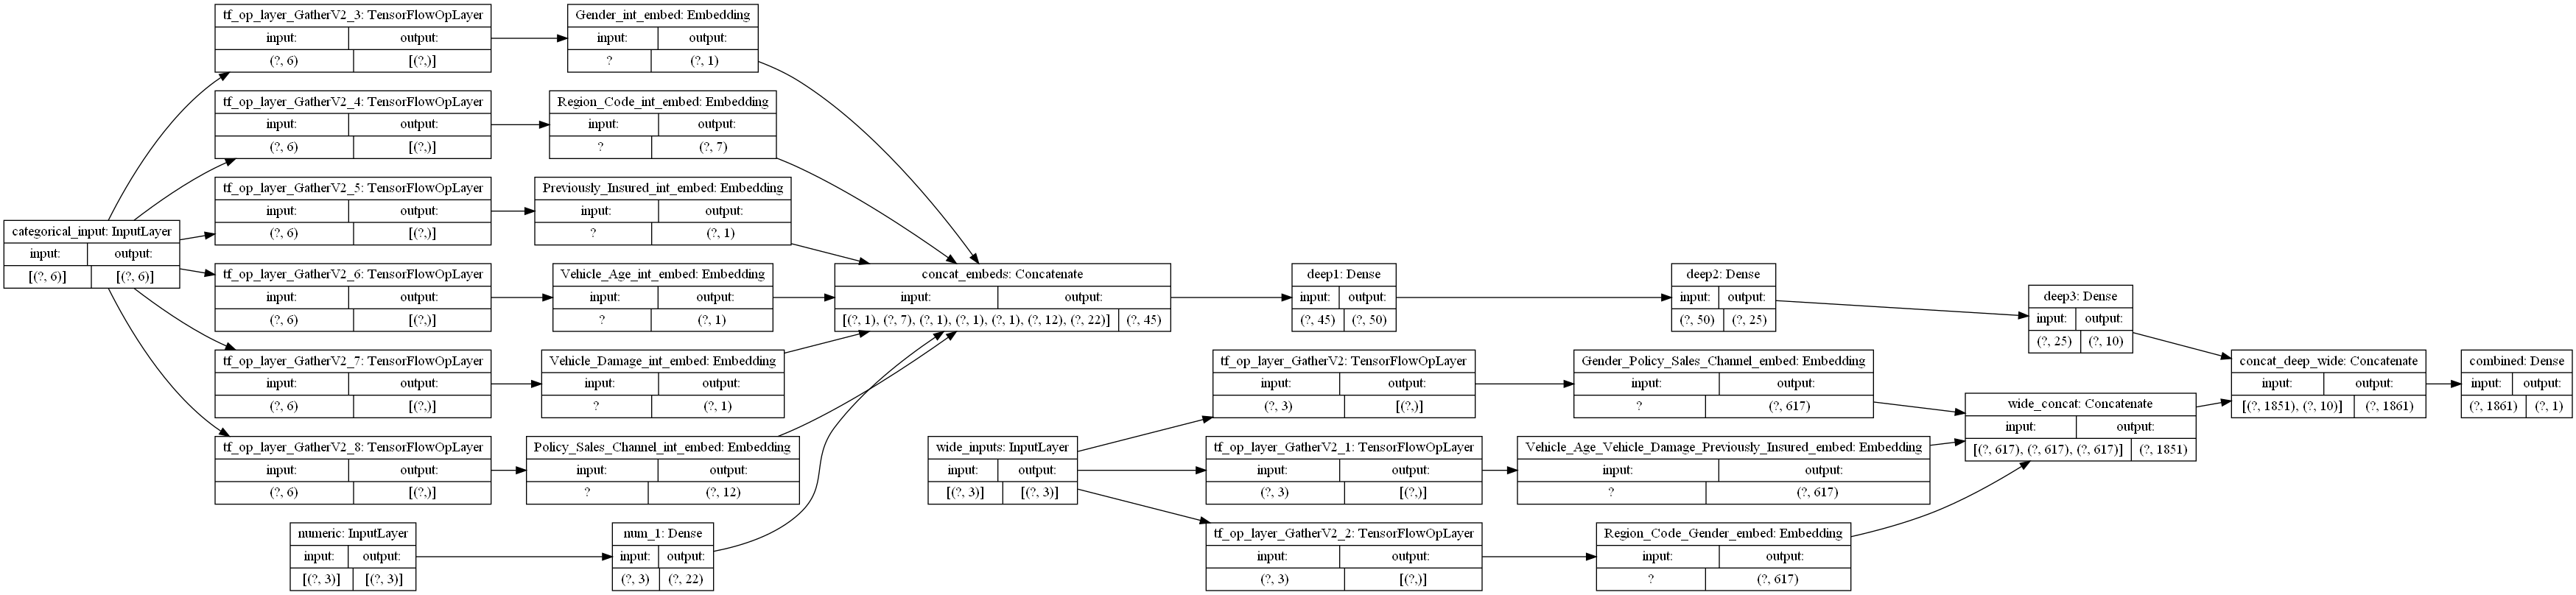

In [14]:
# you will need to install pydot properly on your machine to get this running
plot_model(
    model_1, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

In [15]:
yhat = np.round(model_1.predict([X_test_crossed,X_test_cat,X_test_num]))
print(mt.confusion_matrix(y_test,yhat))
print(mt.classification_report(y_test,yhat))

[[42721 24156]
 [  765  8576]]
              precision    recall  f1-score   support

           0       0.98      0.64      0.77     66877
           1       0.26      0.92      0.41      9341

    accuracy                           0.67     76218
   macro avg       0.62      0.78      0.59     76218
weighted avg       0.89      0.67      0.73     76218



Text(0.5, 0, 'epochs')

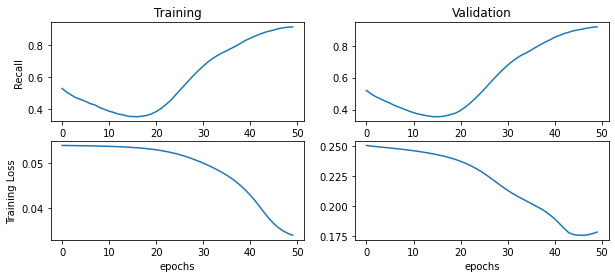

In [16]:
from matplotlib import pyplot as plt

%matplotlib inline

plt.figure(figsize=(10,4))
plt.subplot(2,2,1)
plt.plot(history.history['recall_score'])

plt.ylabel('Recall')
plt.title('Training')
plt.subplot(2,2,2)

plt.plot(history.history['val_recall_score'])
plt.title('Validation')

plt.subplot(2,2,3)
plt.plot(history.history['loss'])
plt.ylabel('Training Loss')
plt.xlabel('epochs')

plt.subplot(2,2,4)
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')

## Stratified 5 Fold

In [17]:
#https://medium.com/@literallywords/stratified-k-fold-with-keras-e57c487b1416
cv = StratifiedKFold(n_splits=5, shuffle=True)
my_scorer = make_scorer(recall_score)

histories_1 = [] 
for index, (train_indices, val_indices) in enumerate(cv.split(X_train, y_train)):
    print(f"Training on fold {index+1}/{5}...")
    
    # get crossed columns for this fold
    _X_train_crossed = X_train_crossed[train_indices]
    _X_test_crossed = X_train_crossed[val_indices]
    
    # save categorical features for this fold
    _X_train_cat = X_train_cat[train_indices]
    _X_test_cat = X_train_cat[val_indices]
    
    #save numeric data for this fold
    _X_train_num =  X_train_num[train_indices]
    _X_test_num =  X_train_num[val_indices]
    
    _y_train = y_train[train_indices]
    _y_test = y_train[val_indices]
    

    _history, _model = model_1_create(_X_train_crossed, _X_test_crossed, _X_train_cat, _X_test_cat,
                            _X_train_num, _X_test_num, _y_train, _y_test)
    
    histories_1.append(_history.history['recall_score'][-1])
    print("Last training recall: ", _history.history['recall_score'][-1])
    _history = None
    _model = None


Training on fold 1/5...
Last training recall:  0.7411520481109619
Training on fold 2/5...
Last training recall:  0.7526928186416626
Training on fold 3/5...
Last training recall:  0.8701454997062683
Training on fold 4/5...
Last training recall:  0.799297571182251
Training on fold 5/5...
Last training recall:  0.7646685242652893


<BarContainer object of 5 artists>

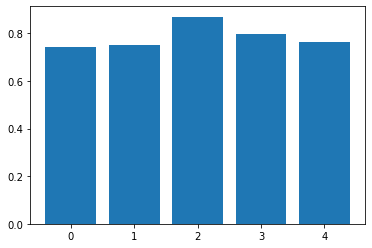

In [18]:
plot_data = np.array(histories_1)
plt.bar(x=range(len(plot_data)),height=plot_data)

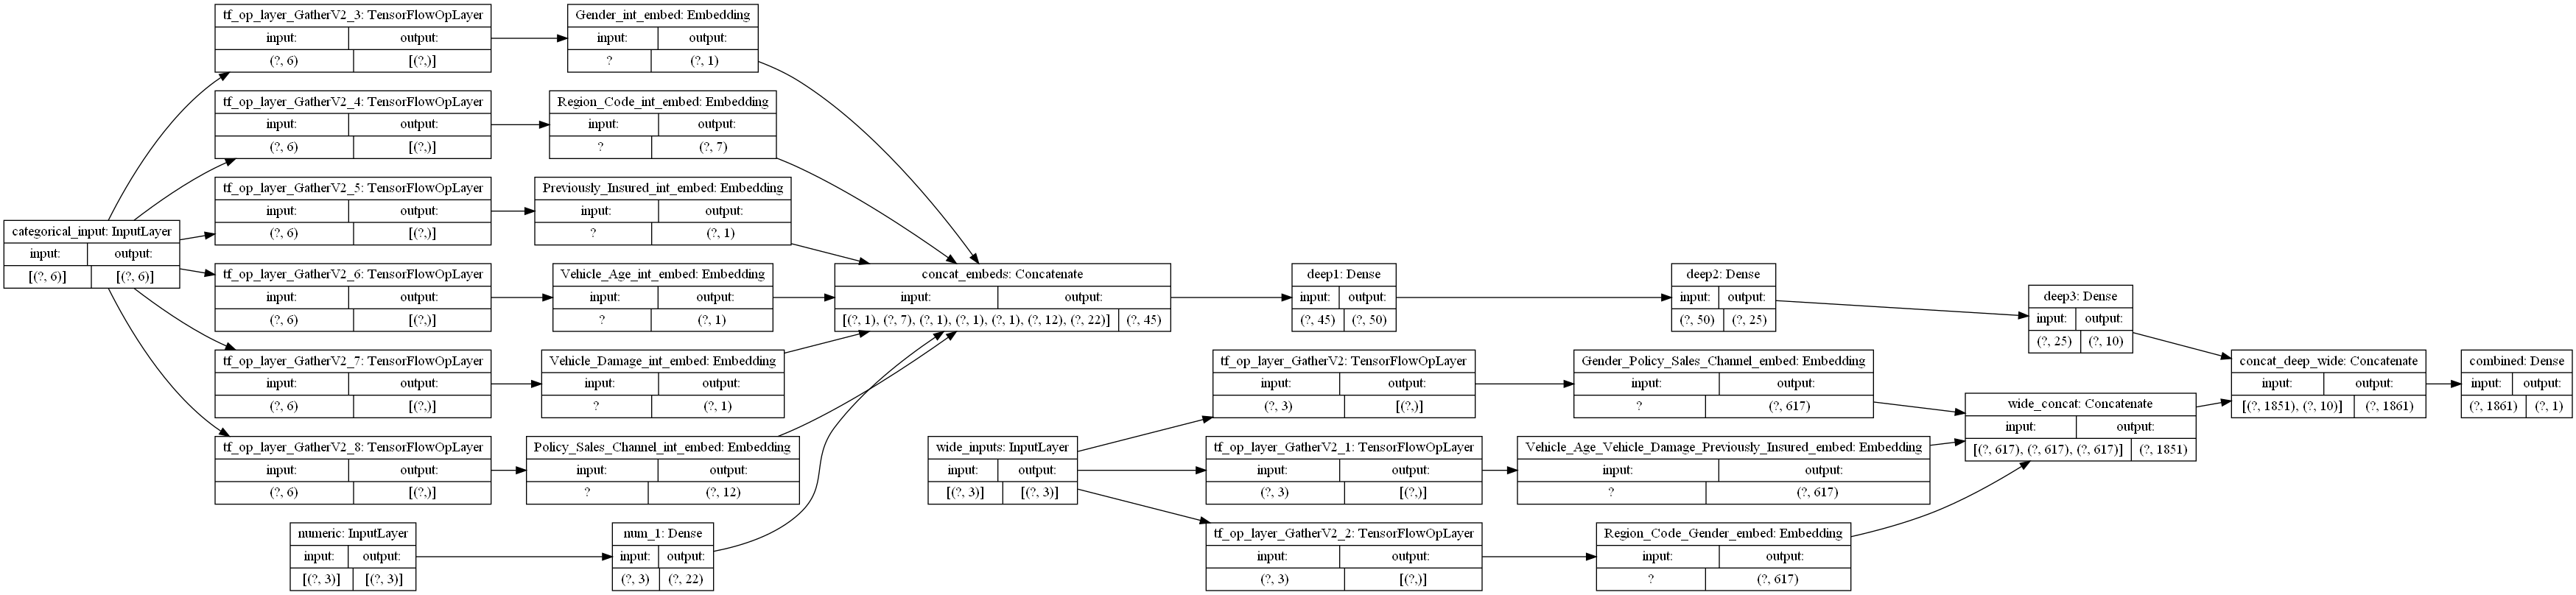

In [19]:
plot_model(
    model_1, to_file='model1.png', show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

## Model 2

For the change in the second model we are increaseing the amount of deep layers and increase the nueron size in general

In [25]:
def model_2_create(_X_train_crossed, _X_test_crossed, _X_train_cat, _X_test_cat,
                   _X_train_num, _X_test_num, _y_train, _y_test, verbose=0):
    # we need to create separate lists for each branch
    crossed_outputs = []

    # CROSSED DATA INPUT
    input_crossed = Input(shape=(_X_train_crossed.shape[1],), dtype='int64', name='wide_inputs')
    for idx,col in enumerate(cross_col_df_names):

        # track what the maximum integer value will be for this variable
        # which is the same as the number of categories
        N = max(df_train[col].max(),df_test[col].max())+1


        # this line of code does this: input_branch[:,idx]
        x = tf.gather(input_crossed, idx, axis=1)

        # now use an embedding to deal with integers as if they were one hot encoded
        x = Embedding(input_dim=N, 
                      output_dim=int(np.sqrt(N)), 
                      input_length=1, name=col+'_embed')(x)

        # save these outputs to concatenate later
        crossed_outputs.append(x)

    # now concatenate the outputs and add a fully connected layer
    wide_branch = concatenate(crossed_outputs, name='wide_concat')

    # reset this input branch
    all_deep_branch_outputs = []

    # CATEGORICAL DATA INPUT
    input_cat = Input(shape=(_X_train_cat.shape[1],), dtype='int64', name='categorical_input')
    for idx,col in enumerate(categorical_headers_ints):

        # track what the maximum integer value will be for this variable
        # which is the same as the number of categories
        N = max(df_train[col].max(),df_test[col].max())+1

        # this line of code does this: input_branch[:,idx]
        x = tf.gather(input_cat, idx, axis=1)

        # now use an embedding to deal with integers as if they were one hot encoded
        x = Embedding(input_dim=N, 
                      output_dim=int(np.sqrt(N)), 
                      input_length=1, name=col+'_embed')(x)

        # save these outputs to concatenate later
        all_deep_branch_outputs.append(x)

    # NUMERIC DATA INPUT
    # create dense input branch for numeric
    input_num = Input(shape=(_X_train_num.shape[1],), name='numeric')
    x_dense = Dense(units=22, activation='relu',name='num_1')(input_num)

    all_deep_branch_outputs.append(x_dense)


    # merge the deep branches together
    deep_branch = concatenate(all_deep_branch_outputs,name='concat_embeds')
    deep_branch = Dense(units=100,activation='relu', name='deep1')(deep_branch)
    deep_branch = Dense(units=50,activation='relu', name='deep2')(deep_branch)
    deep_branch = Dense(units=25,activation='relu', name='deep3')(deep_branch)
    deep_branch = Dense(units=12,activation='relu', name='deep4')(deep_branch)
    deep_branch = Dense(units=6,activation='relu', name='deep5')(deep_branch)

    # merge the deep and wide branch
    final_branch = concatenate([wide_branch, deep_branch],
                               name='concat_deep_wide')
    final_branch = Dense(units=1,activation='sigmoid',
                         name='combined')(final_branch)

    model_1 = None
    model_1 = Model(inputs=[input_crossed,input_cat,input_num], 
                  outputs=final_branch)
    
    model_1.compile(optimizer='adagrad',
                  loss='mean_squared_error',
                  metrics=['accuracy',tf.keras.metrics.Recall(name='recall_score')])

    # lets also add the history variable to see how we are doing
    # and lets add a validation set to keep track of our progress

    c_0 = np.count_nonzero(_y_train)
    c_1 = len(_y_train) - c_0
    w_0 = c_0 / (c_1 + c_0)
    w_1 = c_1 / (c_1 + c_0)
    
    weights = {0: w_0, 1: w_1}
    history = model_1.fit([_X_train_crossed,_X_train_cat,_X_train_num],
                        _y_train, 
                        epochs=80, 
                        batch_size=100, 
                        verbose=verbose, class_weight=weights,
                        validation_data = ([_X_test_crossed,_X_test_cat,_X_test_num],_y_test))
    
    return (history, model_1)

## Run on all the data

In [26]:
history_2, model_2 = model_2_create(X_train_crossed, X_test_crossed, X_train_cat, X_test_cat,
                         X_train_num, X_test_num, y_train, y_test)

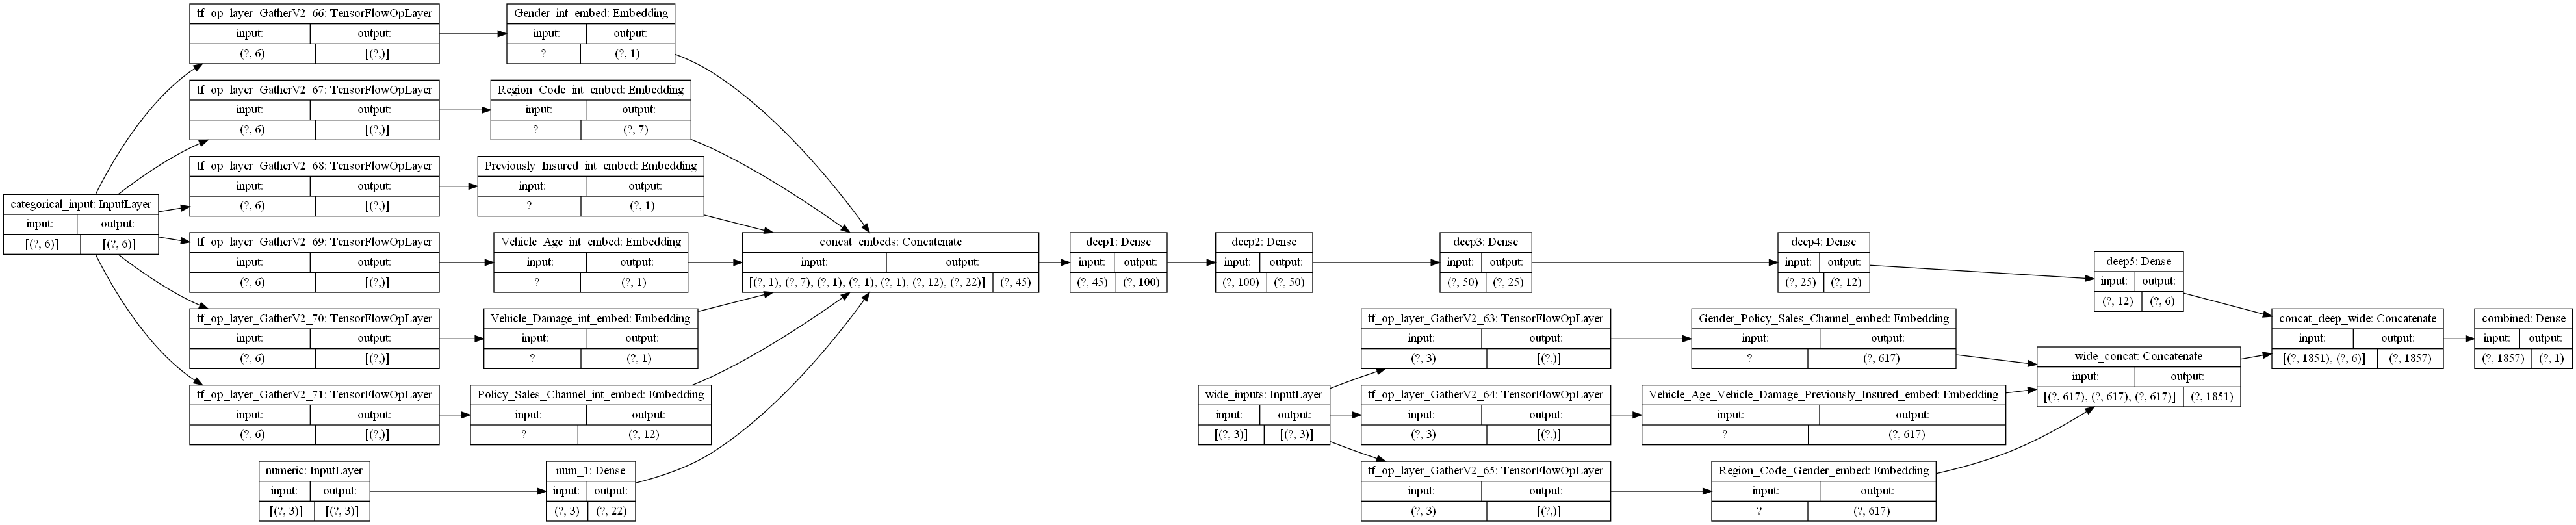

In [27]:
# you will need to install pydot properly on your machine to get this running
plot_model(
    model_2, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

In [28]:
yhat = np.round(model_2.predict([X_test_crossed,X_test_cat,X_test_num]))
print(mt.confusion_matrix(y_test,yhat))
print(mt.classification_report(y_test,yhat))

[[45085 21792]
 [  783  8558]]
              precision    recall  f1-score   support

           0       0.98      0.67      0.80     66877
           1       0.28      0.92      0.43      9341

    accuracy                           0.70     76218
   macro avg       0.63      0.80      0.62     76218
weighted avg       0.90      0.70      0.75     76218



Text(0.5, 0, 'epochs')

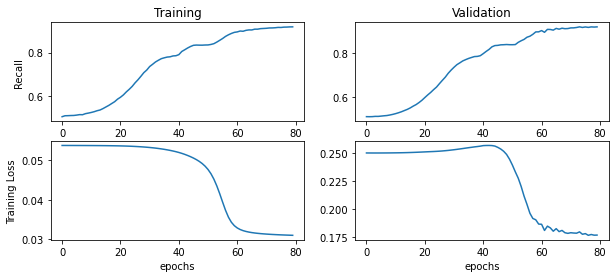

In [29]:
from matplotlib import pyplot as plt

%matplotlib inline

plt.figure(figsize=(10,4))
plt.subplot(2,2,1)
plt.plot(history_2.history['recall_score'])

plt.ylabel('Recall')
plt.title('Training')
plt.subplot(2,2,2)

plt.plot(history_2.history['val_recall_score'])
plt.title('Validation')

plt.subplot(2,2,3)
plt.plot(history_2.history['loss'])
plt.ylabel('Training Loss')
plt.xlabel('epochs')

plt.subplot(2,2,4)
plt.plot(history_2.history['val_loss'])
plt.xlabel('epochs')

## Stratified 5 Fold

In [30]:
#clf = Pipeline([('NN', Model(inputs=[input_crossed,input_cat,input_num], 
#                              outputs=final_branch))])
#https://medium.com/@literallywords/stratified-k-fold-with-keras-e57c487b1416
cv = StratifiedKFold(n_splits=5, shuffle=True)
my_scorer = make_scorer(recall_score)

histories_2 = []
for index, (train_indices, val_indices) in enumerate(cv.split(X_train, y_train)):
    print(f"Training on fold {index+1}/{5}...")
    
    # get crossed columns for this fold
    _X_train_crossed = X_train_crossed[train_indices]
    _X_test_crossed = X_train_crossed[val_indices]
    
    # save categorical features for this fold
    _X_train_cat = X_train_cat[train_indices]
    _X_test_cat = X_train_cat[val_indices]
    
    #save numeric data for this fold
    _X_train_num =  X_train_num[train_indices]
    _X_test_num =  X_train_num[val_indices]
    
    _y_train = y_train[train_indices]
    _y_test = y_train[val_indices]
    
    _history = None
    _model = None
    _history, _model = model_2_create(_X_train_crossed, _X_test_crossed, _X_train_cat, _X_test_cat,
                            _X_train_num, _X_test_num, _y_train, _y_test)
    
    histories_2.append(_history.history['recall_score'][-1])
    print("Last training recall: ", _history.history['recall_score'][-1])
    _history = None
    _model = None
    

Training on fold 1/5...
Last training recall:  0.8318057060241699
Training on fold 2/5...
Last training recall:  0.9049307703971863
Training on fold 3/5...
Last training recall:  0.9203545451164246
Training on fold 4/5...
Last training recall:  0.8091319799423218
Training on fold 5/5...
Last training recall:  0.6171138286590576


<BarContainer object of 5 artists>

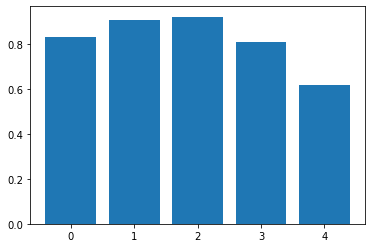

In [33]:
plot_data = np.array(histories_2)
plt.bar(x=range(len(plot_data)),height=plot_data)

## Model 3

In [34]:
def model_3_create(_X_train_crossed, _X_test_crossed, _X_train_cat, _X_test_cat,
                   _X_train_num, _X_test_num, _y_train, _y_test, verbose=0):
    # we need to create separate lists for each branch
    crossed_outputs = []

    # CROSSED DATA INPUT
    input_crossed = Input(shape=(_X_train_crossed.shape[1],), dtype='int64', name='wide_inputs')
    for idx,col in enumerate(cross_col_df_names):

        # track what the maximum integer value will be for this variable
        # which is the same as the number of categories
        N = max(df_train[col].max(),df_test[col].max())+1


        # this line of code does this: input_branch[:,idx]
        x = tf.gather(input_crossed, idx, axis=1)

        # now use an embedding to deal with integers as if they were one hot encoded
        x = Embedding(input_dim=N, 
                      output_dim=int(np.sqrt(N)), 
                      input_length=1, name=col+'_embed')(x)

        # save these outputs to concatenate later
        crossed_outputs.append(x)

    # now concatenate the outputs and add a fully connected layer
    wide_branch = concatenate(crossed_outputs, name='wide_concat')

    # reset this input branch
    all_deep_branch_outputs = []

    # CATEGORICAL DATA INPUT
    input_cat = Input(shape=(_X_train_cat.shape[1],), dtype='int64', name='categorical_input')
    for idx,col in enumerate(categorical_headers_ints):

        # track what the maximum integer value will be for this variable
        # which is the same as the number of categories
        N = max(df_train[col].max(),df_test[col].max())+1

        # this line of code does this: input_branch[:,idx]
        x = tf.gather(input_cat, idx, axis=1)

        # now use an embedding to deal with integers as if they were one hot encoded
        x = Embedding(input_dim=N, 
                      output_dim=int(np.sqrt(N)), 
                      input_length=1, name=col+'_embed')(x)

        # save these outputs to concatenate later
        all_deep_branch_outputs.append(x)

    # NUMERIC DATA INPUT
    # create dense input branch for numeric
    input_num = Input(shape=(_X_train_num.shape[1],), name='numeric')
    x_dense = Dense(units=22, activation='relu',name='num_1')(input_num)

    all_deep_branch_outputs.append(x_dense)


    # merge the deep branches together
    deep_branch = concatenate(all_deep_branch_outputs,name='concat_embeds')
    deep_branch = Dense(units=100,activation='relu', name='deep1')(deep_branch)
    deep_branch = Dense(units=50,activation='relu', name='deep2')(deep_branch)

    # merge the deep and wide branch
    final_branch = concatenate([wide_branch, deep_branch],
                               name='concat_deep_wide')
    final_branch = Dense(units=1,activation='sigmoid',
                         name='combined')(final_branch)

    model_1 = None
    model_1 = Model(inputs=[input_crossed,input_cat,input_num], 
                  outputs=final_branch)
    
    model_1.compile(optimizer='adagrad',
                  loss='mean_squared_error',
                  metrics=['accuracy',tf.keras.metrics.Recall(name='recall_score')])

    # lets also add the history variable to see how we are doing
    # and lets add a validation set to keep track of our progress

    c_0 = np.count_nonzero(_y_train)
    c_1 = len(_y_train) - c_0
    w_0 = c_0 / (c_1 + c_0)
    w_1 = c_1 / (c_1 + c_0)
    
    weights = {0: w_0, 1: w_1}
    history = model_1.fit([_X_train_crossed,_X_train_cat,_X_train_num],
                        _y_train, 
                        epochs=50, 
                        batch_size=100, 
                        verbose=verbose, class_weight=weights,
                        validation_data = ([_X_test_crossed,_X_test_cat,_X_test_num],_y_test))
    
    return (history, model_1)

## Run on all the data

In [35]:
history_3, model_3 = model_3_create(X_train_crossed, X_test_crossed, X_train_cat, X_test_cat,
                         X_train_num, X_test_num, y_train, y_test)

In [36]:
model_3

In [37]:
probas = model_3.predict([X_test_crossed,X_test_cat,X_test_num])
probas

array([[0.06547657],
       [0.73562574],
       [0.78225833],
       ...,
       [0.7953913 ],
       [0.7380769 ],
       [0.7908201 ]], dtype=float32)

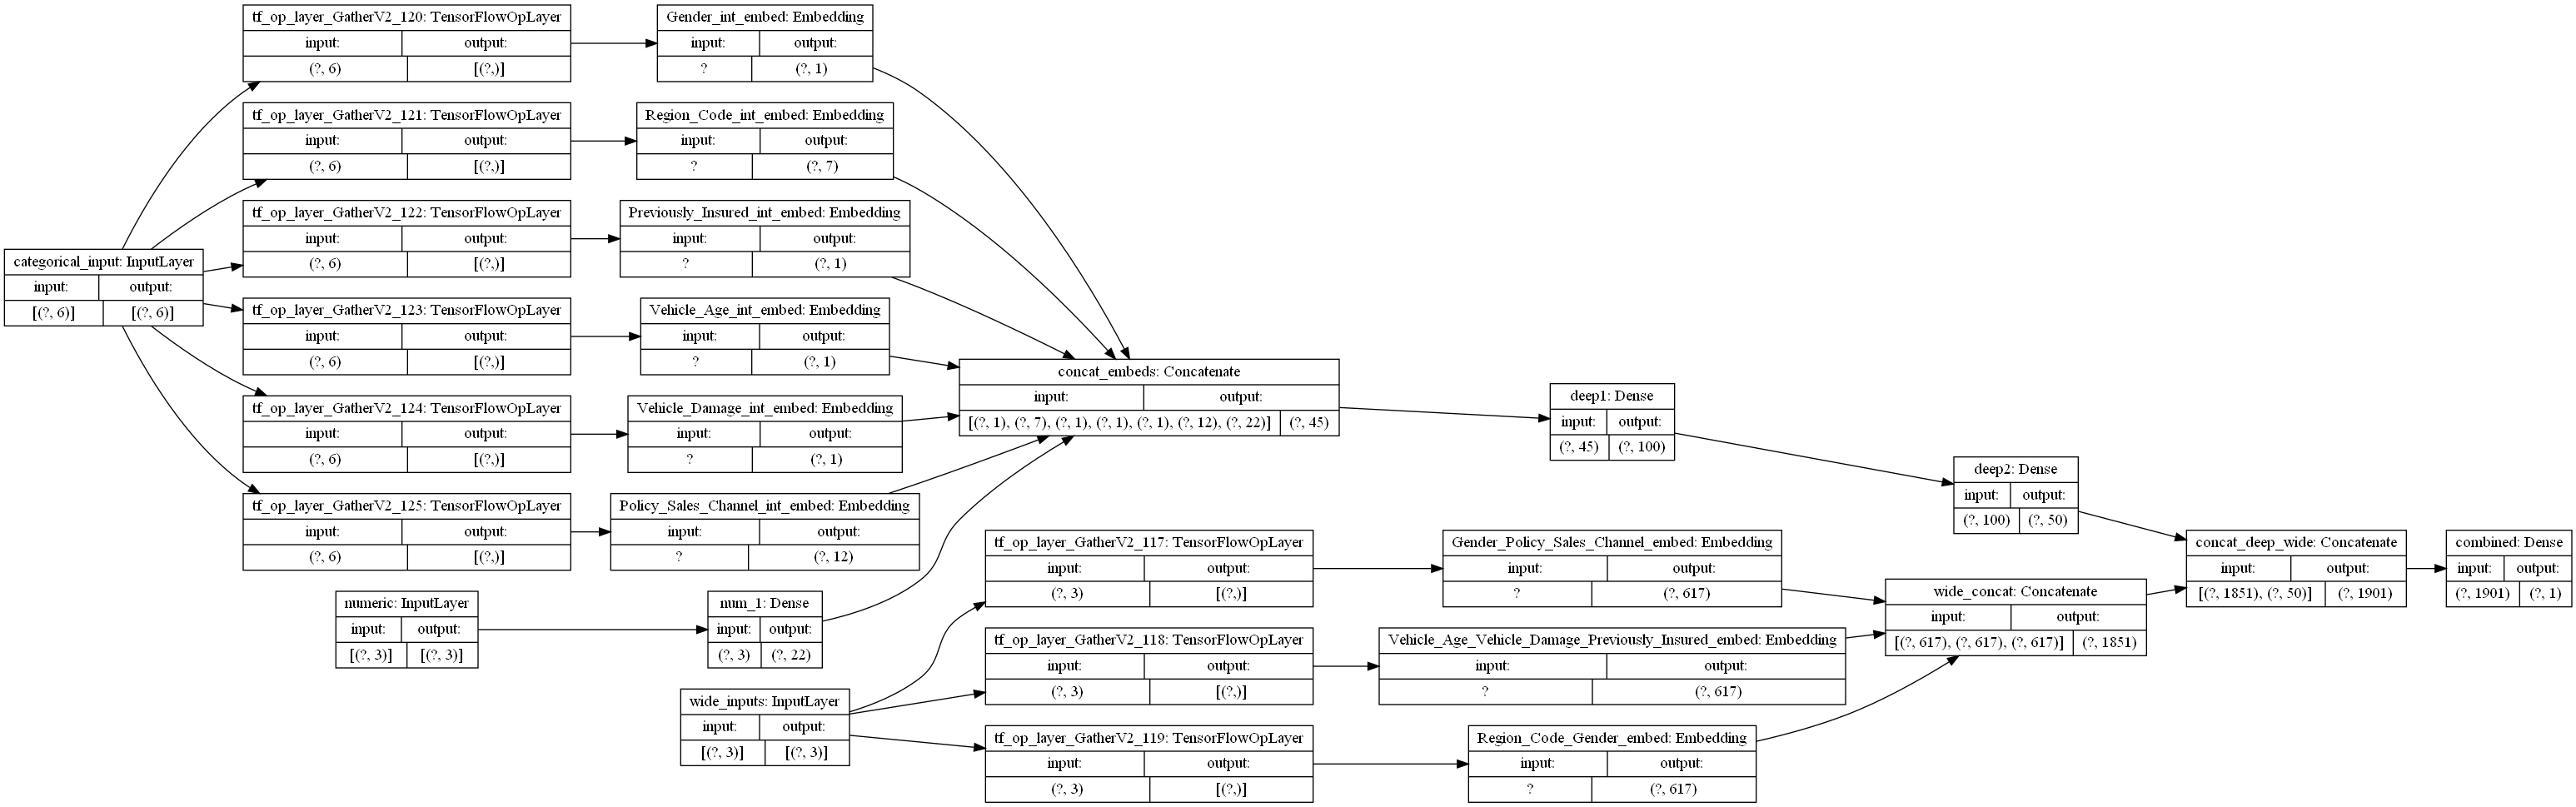

In [38]:
# you will need to install pydot properly on your machine to get this running
plot_model(
    model_3, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

In [40]:
yhat = np.round(model_3.predict([X_test_crossed,X_test_cat,X_test_num]))
print(mt.confusion_matrix(y_test,yhat))
print(mt.classification_report(y_test,yhat))

[[44246 22631]
 [  769  8572]]
              precision    recall  f1-score   support

           0       0.98      0.66      0.79     66877
           1       0.27      0.92      0.42      9341

    accuracy                           0.69     76218
   macro avg       0.63      0.79      0.61     76218
weighted avg       0.90      0.69      0.75     76218



Text(0.5, 0, 'epochs')

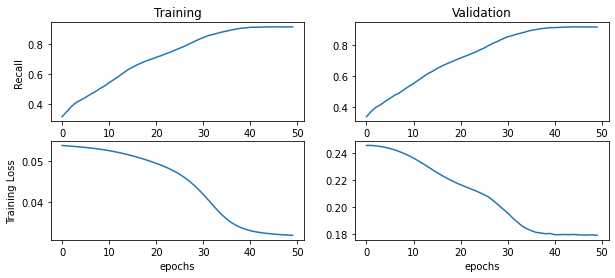

In [41]:
from matplotlib import pyplot as plt

%matplotlib inline

plt.figure(figsize=(10,4))
plt.subplot(2,2,1)
plt.plot(history_3.history['recall_score'])

plt.ylabel('Recall')
plt.title('Training')
plt.subplot(2,2,2)

plt.plot(history_3.history['val_recall_score'])
plt.title('Validation')

plt.subplot(2,2,3)
plt.plot(history_3.history['loss'])
plt.ylabel('Training Loss')
plt.xlabel('epochs')

plt.subplot(2,2,4)
plt.plot(history_3.history['val_loss'])
plt.xlabel('epochs')

## Stratified 5 Fold

In [43]:
# clf = Pipeline([('NN', Model(inputs=[input_crossed,input_cat,input_num], 
#                              outputs=final_branch))])
#https://medium.com/@literallywords/stratified-k-fold-with-keras-e57c487b1416
cv = StratifiedKFold(n_splits=5, shuffle=True)
my_scorer = make_scorer(recall_score)

histories_3 = []
for index, (train_indices, val_indices) in enumerate(cv.split(X_train, y_train)):
    print(f"Training on fold {index+1}/{5}...")
    
    # get crossed columns for this fold
    _X_train_crossed = X_train_crossed[train_indices]
    _X_test_crossed = X_train_crossed[val_indices]
    
    # save categorical features for this fold
    _X_train_cat = X_train_cat[train_indices]
    _X_test_cat = X_train_cat[val_indices]
    
    #save numeric data for this fold
    _X_train_num =  X_train_num[train_indices]
    _X_test_num =  X_train_num[val_indices]
    
    _y_train = y_train[train_indices]
    _y_test = y_train[val_indices]
    

    _history, _model = model_3_create(_X_train_crossed, _X_test_crossed, _X_train_cat, _X_test_cat,
                            _X_train_num, _X_test_num, _y_train, _y_test)
    
    histories_3.append(_history.history['recall_score'][-1])
    print("Last training recall: ", _history.history['recall_score'][-1])
    _history = None
    _model = None
    

Training on fold 1/5...
Last training recall:  0.8385294675827026
Training on fold 2/5...
Last training recall:  0.9030574560165405
Training on fold 3/5...
Last training recall:  0.9237330555915833
Training on fold 4/5...
Last training recall:  0.9316942691802979
Training on fold 5/5...
Last training recall:  0.9130594730377197


<BarContainer object of 5 artists>

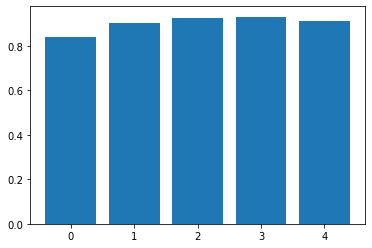

In [44]:
plot_data = np.array(histories_3)
plt.bar(x=range(len(plot_data)),height=plot_data)

## Model Comparison

In [46]:
evals1 = []
for hist in histories_1:
    evals1.append(hist)
evals1

evals2 = []
for hist in histories_2:
    evals2.append(hist)
evals2

evals3 = []
for hist in histories_3:
    evals3.append(hist)
evals3

evals1 = np.asarray(evals1)
evals2 = np.asarray(evals2)
evals3 = np.asarray(evals3)
print('mean of model 1,', np.mean(evals1))
print('mean of model 2,', np.mean(evals2))
print('mean of model 3,', np.mean(evals3))

mean of model 1, 0.7855912923812867
mean of model 2, 0.8166673660278321
mean of model 3, 0.9020147442817688


In [48]:
#===================================================
# Enter your code below
print(np.mean(evals1), np.mean(evals2), np.mean(evals3))

# 1 is the best so check that against each other to make sure it is the 'same'
#1 against 2
t = 1.383  / np.sqrt(10)
e = (1-evals1)-(1-evals2)
stdtot = np.std(e)
dbar = np.mean(e)
print('Range of:', dbar-t*stdtot, dbar+t*stdtot)
#1 against 3
t = 1.383 / np.sqrt(10)
e = (1-evals1)-(1-evals3)
stdtot = np.std(e)
dbar = np.mean(e)
print('Range of:', dbar-t*stdtot, dbar+t*stdtot)
#2 against 3
t = 1.383 / np.sqrt(10)
e = (1-evals2)-(1-evals3)
stdtot = np.std(e)
dbar = np.mean(e)
print('Range of:', dbar-t*stdtot, dbar+t*stdtot)

print('Model 3 has statistically the best recall score 90.20% with 90% confidence')
#===================================================

0.7855912923812867 0.8166673660278321 0.9020147442817688
Range of: -0.013074311969736699 0.07522645926282752
Range of: 0.10036614804714031 0.13248075575382404
Range of: 0.03500747125960279 0.13568728524827073
Model 3 has statistically the best recall score 90.20% with 90% confidence


## Standard MLP

In [49]:
#from sklearn import veresion as sklearn_version
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

#print(sklearn_version)
# these values have been hand tuned
clf = MLPClassifier(hidden_layer_sizes=(50, 25, 12), 
                    activation='relu', # compare to sigmoid
                    solver='adam', 
                    alpha=1e-4, # L2 penalty
                    batch_size=128, # min of 200, num_samples
                    learning_rate='adaptive', # decrease rate if loss goes up
                    #learning_rate_init=0.1, # only SGD
                    #power_t=0.5,    # only SGD with inverse scaling
                    max_iter=200, 
                    shuffle=True, 
                    random_state=1, 
                    tol=1e-9, # for stopping
                    verbose=False, 
                    warm_start=False, 
                    #momentum=0.9, # only SGD
                    #nesterovs_momentum=True, # only SGD
                    early_stopping=False, 
                    validation_fraction=0.1, # only if early_stop is true
                    beta_1=0.9, # adam decay rate of moment
                    beta_2=0.999, # adam decay rate of moment
                    epsilon=1e-08) # adam numerical stabilizer

clf.fit(X_train,y_train)
yhat = clf.predict(X_test)
print('Validation recall:',recall_score(yhat,y_test))
print('Validation Acc:',accuracy_score(yhat,y_test))

Wall time: 5min 59s
Validation recall: 0.5045871559633027
Validation Acc: 0.8774567687422918


In [51]:
(min(yhat),max(yhat))

(0, 1)

In [58]:
wide_deep_probs = model_3.predict([X_test_crossed,X_test_cat,X_test_num])
mlp_probs = clf.predict_proba(X_test)
mlp_probs

array([[9.99988229e-01, 1.17711991e-05],
       [6.53805377e-01, 3.46194623e-01],
       [6.72717756e-01, 3.27282244e-01],
       ...,
       [6.81571575e-01, 3.18428425e-01],
       [7.13096847e-01, 2.86903153e-01],
       [6.41704035e-01, 3.58295965e-01]])

In [53]:
#sorry we are still bad at numpy
l = []
for arr in wide_deep_probs:
    l.append([1-arr[0],arr[0]])
wide_deep_probs = np.array(l)

In [ ]:
mean_fpr

C:\Users\Steven\anaconda3\envs\mlenv2020\lib\site-packages\ipykernel_launcher.py:36: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
C:\Users\Steven\anaconda3\envs\mlenv2020\lib\site-packages\ipykernel_launcher.py:36: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
C:\Users\Steven\anaconda3\envs\mlenv2020\lib\site-packages\ipykernel_launcher.py:36: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
C:\Users\Steven\anaconda3\envs\mlenv2020\lib\site-packages\ipykernel_launcher.py:36: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
C:\Users\Steven\anaconda3\envs\mlenv2020\lib\site-packages\ipykernel_launcher.py:36: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


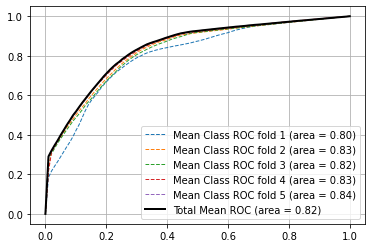

In [55]:
from sklearn.metrics import roc_curve, auc
from scipy import interp
from sklearn.model_selection import StratifiedKFold

K = 5


kfold = StratifiedKFold(n_splits=K).split(X_train, y_train)


mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

for i, (train, test) in enumerate(kfold):
    
    # model coms out fit from create_model
    history, model = model_3_create(X_train_crossed[train], X_train_crossed[test], X_train_cat[train], X_train_cat[test],
                           X_train_num[train], X_train_num[test], y_train[train], y_train[test], verbose=0)
    
    probas = model.predict([X_train_crossed[test],X_train_cat[test],X_train_num[test]])
    # turn predict into a proba format
    l = []
    for arr in probas:
        l.append([1-arr[0],arr[0]])
    probas = np.array(l)

    perclass_mean_tpr = 0.0
    roc_auc = 0
    classes = np.unique(y_train[train])
    # get the mean fpr and tpr, per class
    for j in classes:
        fpr, tpr, thresholds = roc_curve(y_train[test],
                                         probas[:, j],
                                         pos_label=j)
        perclass_mean_tpr += interp(mean_fpr, fpr, tpr)
        perclass_mean_tpr[0] = 0.0
        roc_auc += auc(fpr, tpr)
        
    perclass_mean_tpr /= len(classes)
    roc_auc /= len(classes)
    mean_tpr += perclass_mean_tpr
    plt.plot(mean_fpr,perclass_mean_tpr,'--',lw=1,label='Mean Class ROC fold %d (area = %0.2f)'
                   % (i+1, roc_auc))
    
mean_tpr /= K
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr,perclass_mean_tpr,'k-',lw=2,label='Total Mean ROC (area = %0.2f)'
                   % (mean_auc))
plt.legend(loc='best')
plt.grid()

C:\Users\Steven\anaconda3\envs\mlenv2020\lib\site-packages\ipykernel_launcher.py:50: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
C:\Users\Steven\anaconda3\envs\mlenv2020\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Steven\anaconda3\envs\mlenv2020\lib\site-packages\ipykernel_launcher.py:50: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
C:\Users\Steven\anaconda3\envs\mlenv2020\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Steven\anaconda3\envs\mlenv2020\lib\site-packages\ipykernel_launc

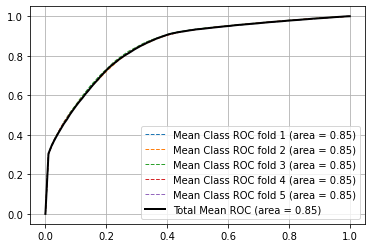

In [61]:
from sklearn.metrics import roc_curve, auc
from scipy import interp
from sklearn.model_selection import StratifiedKFold

K = 5


kfold = StratifiedKFold(n_splits=K).split(X_train, y_train)


mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

for i, (train, test) in enumerate(kfold):
    
    # model coms out fit from create_model
    clf = MLPClassifier(hidden_layer_sizes=(50, 25, 12), 
                    activation='relu', # compare to sigmoid
                    solver='adam', 
                    alpha=1e-4, # L2 penalty
                    batch_size=128, # min of 200, num_samples
                    learning_rate='adaptive', # decrease rate if loss goes up
                    #learning_rate_init=0.1, # only SGD
                    #power_t=0.5,    # only SGD with inverse scaling
                    max_iter=200, 
                    shuffle=True, 
                    random_state=1, 
                    tol=1e-9, # for stopping
                    verbose=False, 
                    warm_start=False, 
                    #momentum=0.9, # only SGD
                    #nesterovs_momentum=True, # only SGD
                    early_stopping=False, 
                    validation_fraction=0.1, # only if early_stop is true
                    beta_1=0.9, # adam decay rate of moment
                    beta_2=0.999, # adam decay rate of moment
                    epsilon=1e-08) # adam numerical stabilizer

    clf.fit(X_train[train],y_train[train])
    probas = clf.predict_proba(X_train[test])
    perclass_mean_tpr = 0.0
    roc_auc = 0
    classes = np.unique(y_train[train])
    # get the mean fpr and tpr, per class
    for j in classes:
        fpr, tpr, thresholds = roc_curve(y_train[test],
                                         probas[:, j],
                                         pos_label=j)
        perclass_mean_tpr += interp(mean_fpr, fpr, tpr)
        perclass_mean_tpr[0] = 0.0
        roc_auc += auc(fpr, tpr)
        
    perclass_mean_tpr /= len(classes)
    roc_auc /= len(classes)
    mean_tpr += perclass_mean_tpr
    plt.plot(mean_fpr,perclass_mean_tpr,'--',lw=1,label='Mean Class ROC fold %d (area = %0.2f)'
                   % (i+1, roc_auc))
    
mean_tpr /= K
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr,perclass_mean_tpr,'k-',lw=2,label='Total Mean ROC (area = %0.2f)'
                   % (mean_auc))
plt.legend(loc='best')
plt.grid()

# Classifying the wieghts

In [156]:
from sklearn.decomposition import PCA

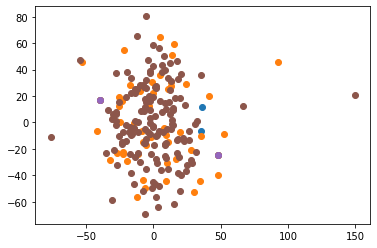

In [157]:
for col in categorical_headers_ints: 
    weights = model_3.get_layer(col+'_embed').get_weights()[0]
    if(len(weights[0]) >= 2):
        pca = PCA(n_components=2)
        pca.fit(weights) # fit data and then transform it
        weights_pca = pca.transform(weights)

        ss = StandardScaler()
        weights_pca = ss.fit_transform(weights_pca)
        weights_pca = ss.transform(weights_pca)
        ax = scatter(weights_pca[:,0],weights_pca[:,1])
    else:
        ax = scatter(weights_pca[0],weights_pca[1])